<a href="https://colab.research.google.com/github/Ziqi-Li/foss4g_23_glasgow/blob/main/notebooks/MGWR_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## An MGWR example to the Berlin Airbnb Dataset

### Ziqi Li (University of Glasgow)

### 0. Pacakge installation and loading

In [1]:
#!pip install geopandas
#!pip install mgwr git+https://github.com/pysal/mgwr.git
#!pip install contextily

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

### 1. Load the dataset then convert it to Web Mercator projection (epsg=3857)

In [3]:
berlin = gpd.read_file("https://raw.githubusercontent.com/Ziqi-Li/foss4g_23_glasgow/main/data/berlin_airbnb.geojson").to_crs(epsg=3857)

In [4]:
berlin.shape

(5874, 19)

In [5]:
berlin.columns

Index(['id', 'last_scraped', 'name', 'house_rules', 'host_id', 'host_since',
       'host_is_superhost', 'instant_bookable', 'neighborhood', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
       'minimum_nights', 'review_scores_rating', 'geometry'],
      dtype='object')

### 2. Create a random sub-sample of the data with only complete records

In [6]:
subset = berlin[["price","review_scores_rating","accommodates","bathrooms","geometry"]]

subset = subset.dropna().sample(800,random_state=1111)

### 3. Data preparation for MGWR
 - Dependent variable y (N,1)
 - Independent varibales X (N, p)
 - Coordinates of the locations (N, 2)
 - MGWR requires data to be standardised with mean of 0 and std of 1

We fit a simple regression model in the form of:

$price = \beta_0 + review score*\beta_0 + accommodates*\beta_0 + bathrooms*\beta_0$ + ϵ

In [7]:
y = subset['price'].values.reshape(-1,1)
X = subset[["review_scores_rating","accommodates","bathrooms"]].values


In [8]:
subset['x'] = subset.geometry.x
subset['y'] = subset.geometry.y
coords = list(zip(subset['x'],subset['y']))

In [9]:
y = (y - y.mean(axis=0))/y.std(axis=0)
X = (X - X.mean(axis=0))/X.std(axis=0)

### 4. Fitting a GWR model
- Step 1: Select the best bandwidth (default setting is adaptive bandwdith (# of neighbours) minimising AICc)
- Step 2: Use the bandwidth to fit the model

In [10]:
gwr_selector = Sel_BW(coords,y,X)
gwr_bw = gwr_selector.search(verbose=True)
print("Optimal BW:", gwr_bw)

Bandwidth:  335.0 , score:  1995.21
Bandwidth:  513.0 , score:  2020.91
Bandwidth:  226.0 , score:  1974.69
Bandwidth:  158.0 , score:  1969.13
Bandwidth:  116.0 , score:  1960.27
Bandwidth:  90.0 , score:  1967.06
Bandwidth:  132.0 , score:  1964.60
Bandwidth:  106.0 , score:  1962.62
Bandwidth:  122.0 , score:  1961.97
Bandwidth:  112.0 , score:  1960.91
Bandwidth:  118.0 , score:  1960.60
Bandwidth:  114.0 , score:  1961.03
Optimal BW: 116.0


In [11]:
gwr_rslt = GWR(coords,y,X,gwr_bw).fit()

#### A summary of GWR results
- The summary starts with global linear regression results
- Followed by GWR results

In [12]:
gwr_rslt.summary()

Model type                                                         Gaussian
Number of observations:                                                 800
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            622.521
Log-likelihood:                                                   -1034.817
AIC:                                                               2077.635
AICc:                                                              2079.710
BIC:                                                              -4698.429
R2:                                                                   0.222
Adj. R2:                                                              0.219

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5. Fitting an MGWR model
- Step 1: Select the best bandwidths using iterative back-fitting.
- Step 2: Use the bandwidths (note in MGWR we pass the entire `selector` class) to fit the model.

In [13]:
mgwr_selector = Sel_BW(coords,y,X,multi=True)
mgwr_bw = mgwr_selector.search()
print("Optimal BWs:",mgwr_bw)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Optimal BWs: [127. 798.  44. 231.]


In [14]:
mgwr_rslt = MGWR(coords,y,X,selector=mgwr_selector).fit()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
mgwr_rslt.summary()

Model type                                                         Gaussian
Number of observations:                                                 800
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            622.521
Log-likelihood:                                                   -1034.817
AIC:                                                               2077.635
AICc:                                                              2079.710
BIC:                                                              -4698.429
R2:                                                                   0.222
Adj. R2:                                                              0.219

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 6. Visualise MGWR results

`mgwr_rslt.params` returns the local coefficients (N, p+1)

`mgwr_rslt.tvalues` returns the local t-values (N, p+1)

In [16]:
mgwr_rslt.params

array([[ 0.03499099,  0.04126076,  0.11836083,  0.06858903],
       [-0.0333831 ,  0.04087232,  0.80074018,  0.23972901],
       [ 0.62564931,  0.04162167,  0.68952354,  0.17909218],
       ...,
       [ 0.04702339,  0.04157908,  0.96679978,  0.23305758],
       [-0.04276727,  0.03879731,  0.85742611,  0.1490553 ],
       [-0.39366464,  0.04757789,  0.4765546 ,  0.16025912]])

In [17]:
mgwr_rslt.tvalues

array([[ 0.39676132,  1.41137734,  0.46216467,  1.01072325],
       [-0.38979811,  1.4101843 ,  6.71836329,  2.6862959 ],
       [ 7.61092286,  1.44174035,  6.24151344,  2.03146623],
       ...,
       [ 0.58123719,  1.43735584,  6.97917337,  2.58301354],
       [-0.43846942,  1.33820161,  5.14421189,  2.11824474],
       [-2.77141582,  1.6250151 ,  2.71746039,  1.189683  ]])

`mgwr_rslt.filter_tvals()` filters insignificant coefficients (p<0.05, after adjusting for multiple testing) as zeros.

In [18]:
mgwr_rslt.params[mgwr_rslt.filter_tvals() == 0] = np.nan

In [19]:
mgwr_rslt.params

array([[       nan,        nan,        nan,        nan],
       [       nan,        nan, 0.80074018,        nan],
       [0.62564931,        nan, 0.68952354,        nan],
       ...,
       [       nan,        nan, 0.96679978,        nan],
       [       nan,        nan, 0.85742611,        nan],
       [       nan,        nan,        nan,        nan]])

Mapping local coefficients

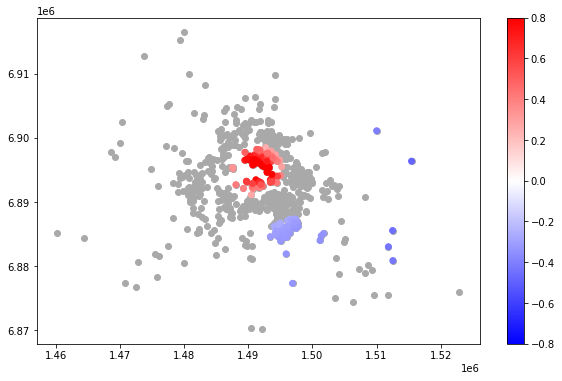

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
# Use grey to show locations with insignificant coefficients
subset.plot(color='darkgrey',ax=ax)
# Plot significant local coefficients for Intercept
subset.plot(mgwr_rslt.params[:,0],legend=True,cmap="bwr",ax=ax,vmin=-0.8,vmax=0.8)

Text(0.5, 1.0, 'review_scores_rating')

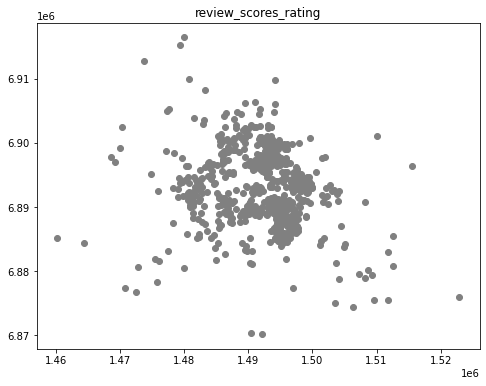

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
# Plot significant local coefficients for X1
if np.sum(~np.isnan(mgwr_rslt.params[:,1])) > 0:
    subset.plot(mgwr_rslt.params[:,1],legend=True,cmap="bwr",ax=ax,vmin=-0.8,vmax=0.8)

plt.title("review_scores_rating")

Text(0.5, 1.0, 'accommodates')

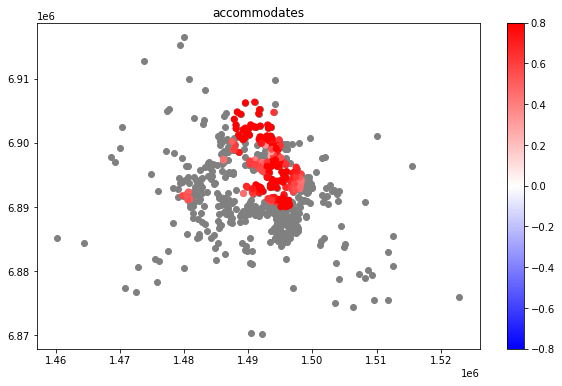

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
subset.plot(mgwr_rslt.params[:,2],legend=True,cmap="bwr",ax=ax,vmin=-0.8,vmax=0.8)

plt.title("accommodates")

Text(0.5, 1.0, 'bathrooms')

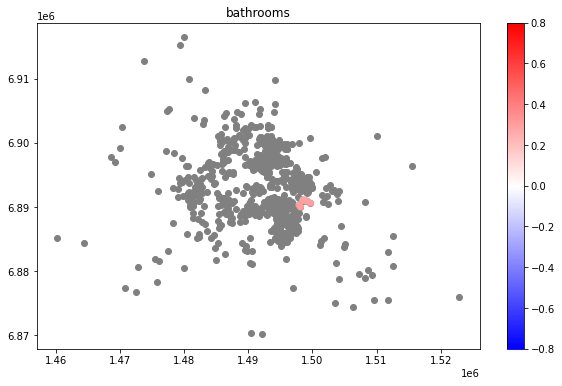

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
subset.plot(mgwr_rslt.params[:,3],legend=True,cmap="bwr",ax=ax,vmin=-0.8,vmax=0.8)

plt.title("bathrooms")

Add a basemap tile to provide a bit more context. An alternative option is to add an interactive basemap using `folium`.

Text(0.5, 1.0, 'accommodates')

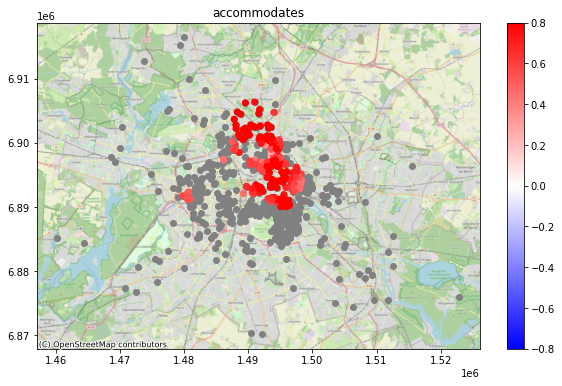

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
subset.plot(mgwr_rslt.params[:,2],legend=True,cmap="bwr",ax=ax,vmin=-0.8,vmax=0.8)

#Add a basemap using contextuality package
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik)

plt.title("accommodates")

References

Oshan, T. M., Li, Z., Kang, W., Wolf, L. J., & Fotheringham, A. S. (2019). mgwr: A Python implementation of multiscale geographically weighted regression for investigating process spatial heterogeneity and scale. ISPRS International Journal of Geo-Information, 8(6), 269.

Wolf, L. J. (2019). Learn about geographically weighted models in python using airbnb data in berlin residential districts (2018). In SAGE Research Methods Datasets Part 2. SAGE Publications, Ltd. https://dx.doi.org/10.4135/9781526499578